In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from sqlalchemy import create_engine
from keras.models import Sequential
import matplotlib.pyplot as plt
from datetime import datetime
import tensorflow as tf
from numpy import NaN
from tqdm import tqdm
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import psycopg2
import urllib
import keras
import os

<font size="30">Connect to the database</font>


In [2]:
#connect to the database
conn = psycopg2.connect(database='Value_Added_data_drought',
                        user="postgres",
                        password="1!qaz2@wsx",
                        host="140.134.51.64",
                        port="5432")
engine = create_engine('postgresql+psycopg2://postgres:%s@140.134.51.64/Value_Added_data_drought'%urllib.parse.quote_plus('1!qaz2@wsx'))
cur = conn.cursor()

In [3]:
#connect to the database
conn = psycopg2.connect(database='Value_Added_data_drought',
                        user="postgres",
                        password="1!qaz2@wsx",
                        host="140.134.51.64",
                        port="5432")
engine = create_engine('postgresql+psycopg2://postgres:%s@140.134.51.64/Value_Added_data_drought'%urllib.parse.quote_plus('1!qaz2@wsx'))
cur = conn.cursor()


query = f'select * from public."FCU_grid_to_area_code_1km_37134"'
DFFF = pd.read_sql(query,con=engine)

In [ ]:
DFFF[DFFF['COUNTYNAME']=='桃園市']

<font size="30">data processing(2010/01/01-2022/12/31)</font>


In [4]:
#data cleaning process
def data_processing(dataset) -> pd.DataFrame:
    dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')
    start_date = pd.to_datetime('2010-01-01')
    end_date = pd.to_datetime('2022-12-31')
    dataset_2020_2022 = dataset.query('date >= @start_date and date <= @end_date')
    dataset_2020_2022 = dataset_2020_2022[['date','grid','value']]
    dataset_2020_2022['value'].fillna(int(0),inplace=True)
    dataset_2020_2022['value'] = dataset_2020_2022['value'].astype('float')
    dataset_2020_2022 = dataset_2020_2022.groupby('grid').apply(lambda x: x.sort_values('date', ascending=True)).reset_index(drop=True)
    return dataset_2020_2022

#get the DSCI,SRSI, SPI, SSI data from the database 
def get_data_from_database(database_table:str)->pd.DataFrame:
    query = f'select * from "{database_table}"'
    df = pd.read_sql(query,con=engine)
    return df

df_DSCI = get_data_from_database('New_fcu_DSCI_City_mode_a_day')

#get the DSCI 
database_table = 'New_fcu_DSCI_City_mode_a_day'
query = f'select * from "{database_table}"'
df_DSCI = pd.read_sql(query,con=engine)

#get the SRSI
database_table = 'New_wra_City_srsi_day'
query = f'select * from "{database_table}"'
City_srsi = pd.read_sql(query,con=engine)

#get the SPI
database_table = 'New_qpesum_City_spi_day'
query = f'select * from "{database_table}"'
City_spi = pd.read_sql(query,con=engine)

#get the SSI
database_table = 'New_wra_City_ssi_day'
query = f'select * from "{database_table}"'
df_SSI = pd.read_sql(query,con=engine)

#conduct cleaning process
df_DSCI_2020_2022 = data_processing(df_DSCI)
df_SSI_2020_2022 = data_processing(df_SSI)
City_spi_2020_2022 = data_processing(City_spi)
City_srsi_2020_2022 = data_processing(City_srsi)

<font size="30">Merge each city code with its DSCI/SSI/SPI/SRSI values</font>

In [5]:
# Merge DataFrames outside the loop
merged_df_base = df_DSCI_2020_2022.merge(df_SSI_2020_2022, on=['date', 'grid'], how='left', suffixes=('_DSCI', '_SSI'))
merged_df_base = merged_df_base.merge(City_spi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SSI', '_SPI'))
merged_df_base = merged_df_base.merge(City_srsi_2020_2022, on=['date', 'grid'], how='left', suffixes=('_SPI', '_SRSI'))

output_dict = {}  # Initialize the output dictionary

# Iterate over grids
for i in tqdm(df_DSCI_2020_2022['grid']):
    merged_df = merged_df_base[merged_df_base['grid'] == i].copy()  # Filter merged_df_base for current grid

    # Drop columns with all NaN values
    if np.isnan(merged_df['value_SSI']).all():
        merged_df.drop(columns='value_SSI', inplace=True)
    if np.isnan(merged_df['value_SRSI']).all():
        merged_df.drop(columns='value_SRSI', inplace=True)
    else:
        merged_df[['value_SSI','value_SRSI']] = merged_df[['value_SSI','value_SRSI']].astype('float')

    output_dict[i] = merged_df

# Process the individual merged DataFrames
for i, merged_df in output_dict.items():
    # Perform any further operations or analysis on each merged_df
    print(f"Output for grid {i}:")
    print(merged_df)
    print("-------------------")


100%|██████████| 90212/90212 [01:32<00:00, 977.23it/s] 

Output for grid 10002:
           date   grid  value_DSCI  value_SPI
0    2010-01-01  10002         1.0      -0.67
1    2010-01-02  10002         1.0      -0.74
2    2010-01-03  10002         1.0      -0.49
3    2010-01-04  10002         1.0      -0.49
4    2010-01-05  10002         1.0      -0.43
...         ...    ...         ...        ...
4743 2022-12-27  10002         0.0       0.29
4744 2022-12-28  10002         0.0       0.40
4745 2022-12-29  10002         0.0       0.51
4746 2022-12-30  10002         0.0       0.50
4747 2022-12-31  10002         0.0       0.52

[4748 rows x 4 columns]
-------------------
Output for grid 10004:
           date   grid  value_DSCI  value_SSI  value_SPI  value_SRSI
4748 2010-01-01  10004         1.5      -1.49      -0.10       -0.25
4749 2010-01-02  10004         1.5      -1.45       0.19       -0.46
4750 2010-01-03  10004         1.5      -1.40       0.39       -0.47
4751 2010-01-04  10004         1.0      -1.24       0.39       -0.49
4752 2010-01

In [6]:
df_68000_DSCI = output_dict[68000][['date','value_DSCI']]
df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
df_68000_DSCI['value_DSCI(t-2)'] = df_68000_DSCI['value_DSCI'].shift(2)
df_68000_DSCI['value_DSCI(t-3)'] = df_68000_DSCI['value_DSCI'].shift(3)
df_68000_DSCI['value_DSCI(t-4)'] = df_68000_DSCI['value_DSCI'].shift(4)
df_68000_DSCI['value_DSCI(t-5)'] = df_68000_DSCI['value_DSCI'].shift(5)
df_68000_DSCI['value_DSCI(t-6)'] = df_68000_DSCI['value_DSCI'].shift(6)
df_68000_DSCI['value_DSCI(t-7)'] = df_68000_DSCI['value_DSCI'].shift(7)
df_68000_DSCI['value_DSCI(t-8)'] = df_68000_DSCI['value_DSCI'].shift(8)
df_68000_DSCI['value_DSCI(t-9)'] = df_68000_DSCI['value_DSCI'].shift(9)
df_68000_DSCI['value_DSCI(t-10)'] = df_68000_DSCI['value_DSCI'].shift(10)
df_68000_DSCI['value_DSCI(t-11)'] = df_68000_DSCI['value_DSCI'].shift(11)
df_68000_DSCI['value_DSCI(t-12)'] = df_68000_DSCI['value_DSCI'].shift(12)
df_68000_DSCI['value_DSCI(t-13)'] = df_68000_DSCI['value_DSCI'].shift(13)
df_68000_DSCI['value_DSCI(t-14)'] = df_68000_DSCI['value_DSCI'].shift(14)
df_68000_DSCI['value_DSCI(t-15)'] = df_68000_DSCI['value_DSCI'].shift(15)
df_68000_DSCI['value_DSCI(t-16)'] = df_68000_DSCI['value_DSCI'].shift(16)
df_68000_DSCI['value_DSCI(t-17)'] = df_68000_DSCI['value_DSCI'].shift(17)
df_68000_DSCI['value_DSCI(t-18)'] = df_68000_DSCI['value_DSCI'].shift(18)
df_68000_DSCI['value_DSCI(t-19)'] = df_68000_DSCI['value_DSCI'].shift(19)
df_68000_DSCI['value_DSCI(t-20)'] = df_68000_DSCI['value_DSCI'].shift(20)
df_68000_DSCI['value_DSCI(t-21)'] = df_68000_DSCI['value_DSCI'].shift(21)
df_68000_DSCI['value_DSCI(t-22)'] = df_68000_DSCI['value_DSCI'].shift(22)
df_68000_DSCI['value_DSCI(t-23)'] = df_68000_DSCI['value_DSCI'].shift(23)
df_68000_DSCI['value_DSCI(t-24)'] = df_68000_DSCI['value_DSCI'].shift(24)
df_68000_DSCI['value_DSCI(t-25)'] = df_68000_DSCI['value_DSCI'].shift(25)
df_68000_DSCI['value_DSCI(t-26)'] = df_68000_DSCI['value_DSCI'].shift(26)
df_68000_DSCI['value_DSCI(t-27)'] = df_68000_DSCI['value_DSCI'].shift(27)
df_68000_DSCI['value_DSCI(t-28)'] = df_68000_DSCI['value_DSCI'].shift(28)
df_68000_DSCI['value_DSCI(t-29)'] = df_68000_DSCI['value_DSCI'].shift(29)
df_68000_DSCI['value_DSCI(t-30)'] = df_68000_DSCI['value_DSCI'].shift(30)
df_68000_DSCI

C:\Users\tangkai\AppData\Local\Temp\ipykernel_13576\2509044449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_13576\2509044449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t-2)'] = df_68000_DSCI['value_DSCI'].shift(2)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_13576\2509044449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,date,value_DSCI,value_DSCI(t-1),value_DSCI(t-2),value_DSCI(t-3),value_DSCI(t-4),value_DSCI(t-5),value_DSCI(t-6),value_DSCI(t-7),value_DSCI(t-8),...,value_DSCI(t-21),value_DSCI(t-22),value_DSCI(t-23),value_DSCI(t-24),value_DSCI(t-25),value_DSCI(t-26),value_DSCI(t-27),value_DSCI(t-28),value_DSCI(t-29),value_DSCI(t-30)
85464,2010-01-01,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85465,2010-01-02,1.50,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85466,2010-01-03,1.50,1.50,1.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85467,2010-01-04,1.00,1.50,1.50,1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85468,2010-01-05,1.00,1.00,1.50,1.50,1.50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90207,2022-12-27,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90208,2022-12-28,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90209,2022-12-29,0.33,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90210,2022-12-30,0.00,0.33,0.33,0.33,0.33,0.33,0.33,0.00,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33


In [7]:
df_68000_DSCI

,date,value_DSCI,value_DSCI(t-1),value_DSCI(t-2),value_DSCI(t-3),value_DSCI(t-4),value_DSCI(t-5),value_DSCI(t-6),value_DSCI(t-7),value_DSCI(t-8),...,value_DSCI(t-21),value_DSCI(t-22),value_DSCI(t-23),value_DSCI(t-24),value_DSCI(t-25),value_DSCI(t-26),value_DSCI(t-27),value_DSCI(t-28),value_DSCI(t-29),value_DSCI(t-30)
85464,2010-01-01,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85465,2010-01-02,1.50,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85466,2010-01-03,1.50,1.50,1.50,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85467,2010-01-04,1.00,1.50,1.50,1.50,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85468,2010-01-05,1.00,1.00,1.50,1.50,1.50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90207,2022-12-27,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90208,2022-12-28,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90209,2022-12-29,0.33,0.33,0.33,0.33,0.33,0.33,0.00,0.33,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33
90210,2022-12-30,0.00,0.33,0.33,0.33,0.33,0.33,0.33,0.00,0.33,...,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33,0.33


Build up the model.

In [8]:
X = df_68000_DSCI[df_68000_DSCI.columns[2:]]  
y = df_68000_DSCI['value_DSCI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # Use 'regression' for numeric targets
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 5,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_leaves': 50,  # Adjust this parameter
    'max_depth': 10,  # Adjust this parameter
}

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Train the model
num_boost_round = 100
model = lgb.train(params, train_data, num_boost_round=num_boost_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

Evaluate the performance of the model.

In [9]:
# Make predictions on the test dataset
y_pred = model.predict(X_test)

# Evaluate the model's performance
from sklearn.metrics import mean_squared_error

# For regression tasks, calculate the mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print('R-squared:', r2)
# Alternatively, you can calculate other evaluation metrics such as R-squared (R2), mean absolute error (MAE), etc.

# Print the evaluation metric
print("Mean Squared Error (MSE):", mse)


R-squared: 0.9206486387722126
Mean Squared Error (MSE): 0.025947997148433356


<font size="30">Train the data</font>

10002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

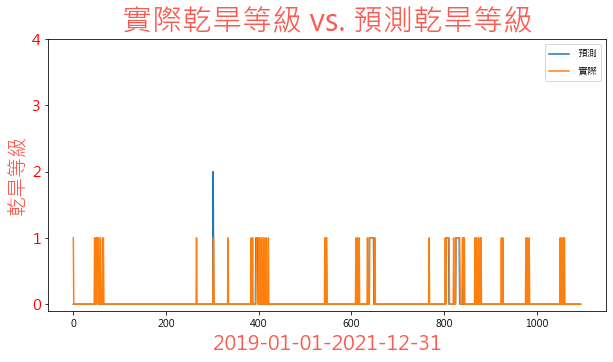

[[1005   52    0]
 [   5   33    0]
 [   0    1    0]]


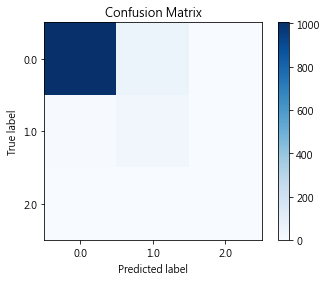

10004
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

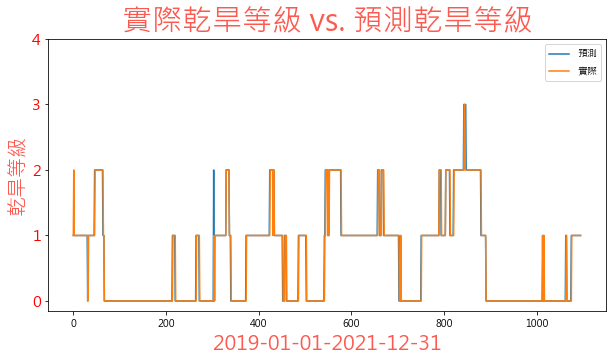

[[541  13   0   0]
 [ 14 370   9   0]
 [  1   9 134   0]
 [  0   0   3   2]]


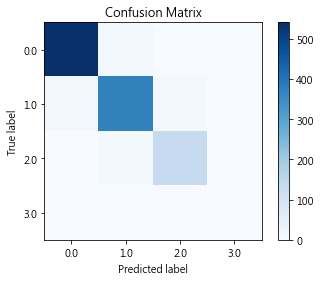

10005
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

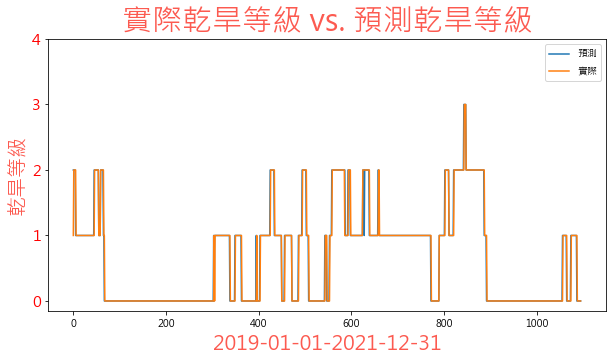

[[537  11   0   0]
 [ 11 365   9   0]
 [  0  10 148   0]
 [  0   0   1   4]]


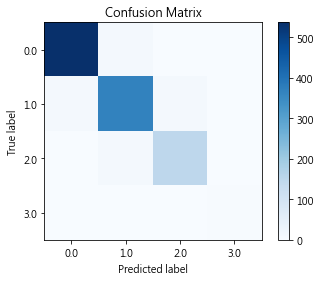

10007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

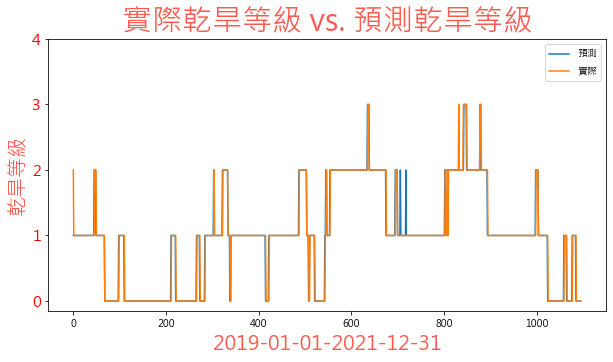

[[268  10   0   0]
 [ 10 540   6   0]
 [  0  15 231   4]
 [  0   0   1  11]]


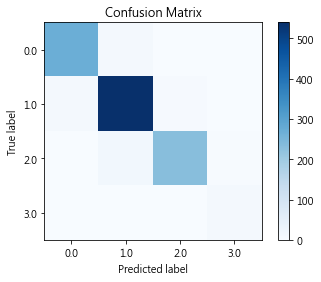

10008
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

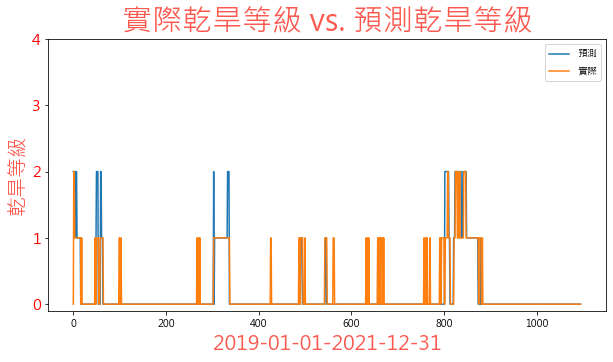

[[904  61   0]
 [  2  80   0]
 [  2  32  15]]


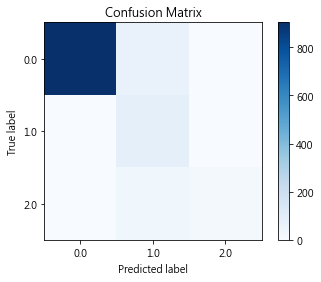

10009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

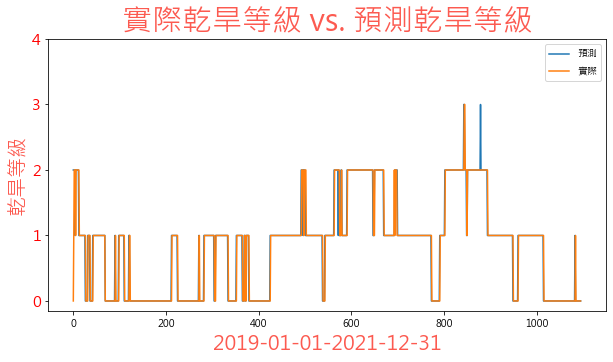

[[365  17   0   0]
 [ 17 482  12   0]
 [  1  12 186   1]
 [  0   0   2   1]]


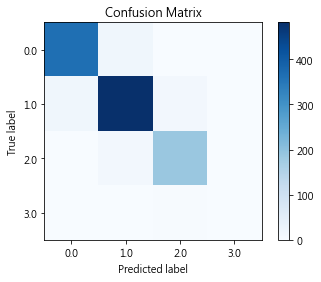

10010
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

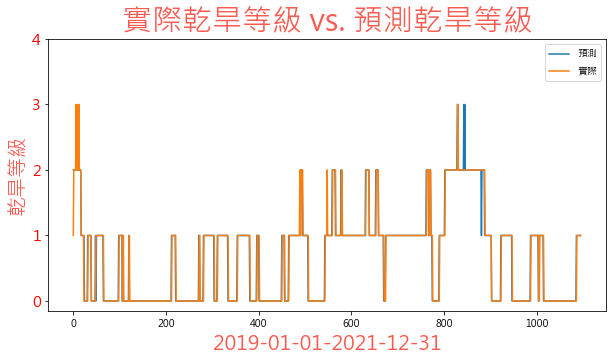

[[482  18   0   0]
 [ 21 430   8   0]
 [  0   9 121   3]
 [  0   0   3   1]]


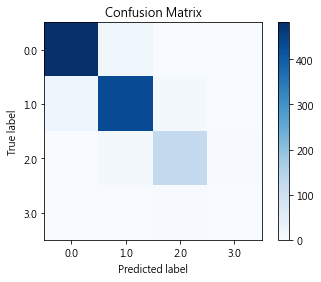

10013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

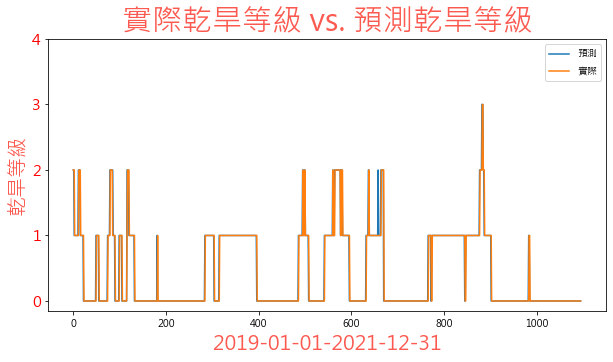

[[665  14   1   0]
 [ 13 340   6   0]
 [  0  13  41   0]
 [  0   0   1   2]]


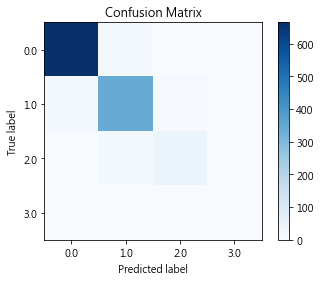

10014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

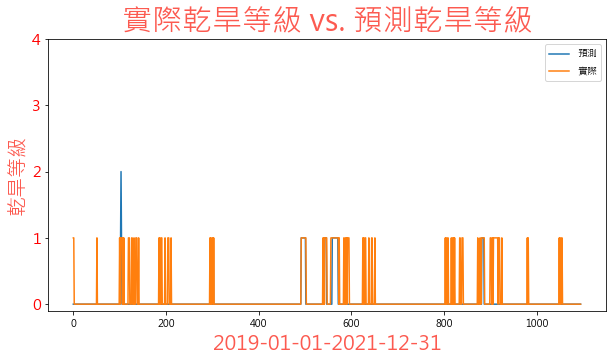

[[962  97   0]
 [  2  34   0]
 [  0   1   0]]


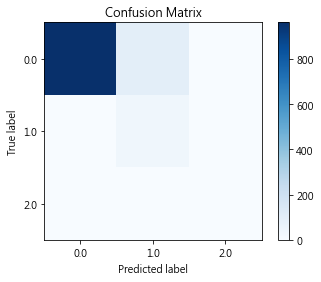

10015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

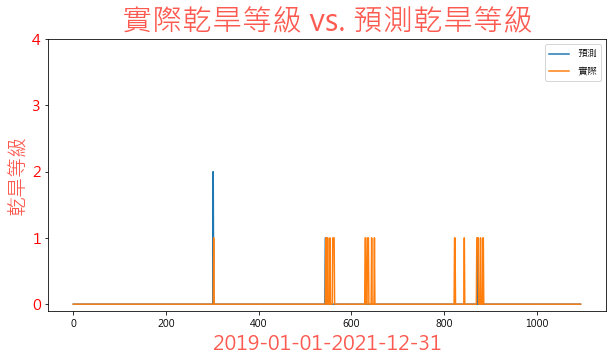

[[1067   24    0]
 [   1    3    0]
 [   1    0    0]]


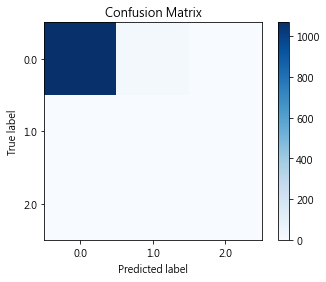

10017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

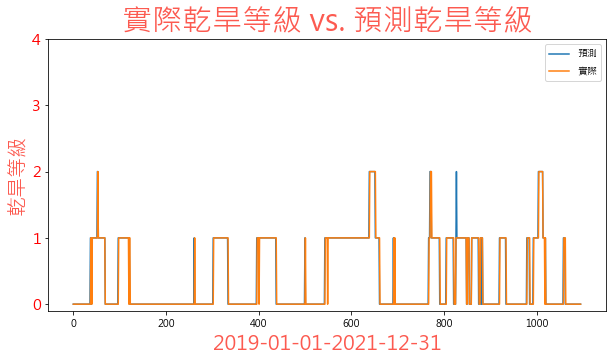

[[691  16   0]
 [ 20 338   2]
 [  0   5  24]]


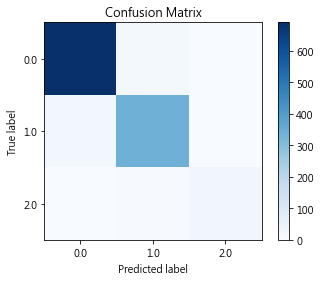

10018
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

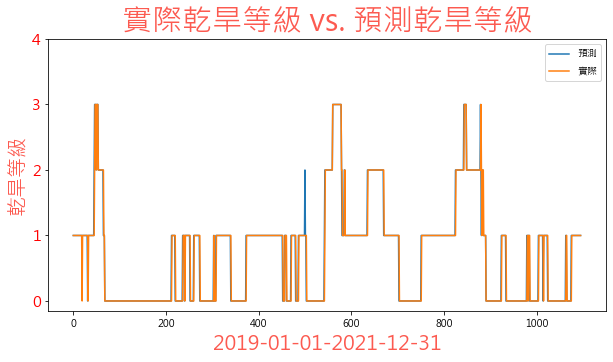

[[474  18   0   0]
 [ 21 424   5   0]
 [  0   7 112   2]
 [  0   0   4  29]]


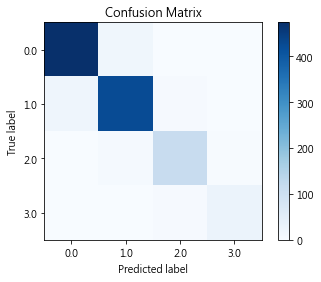

10020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

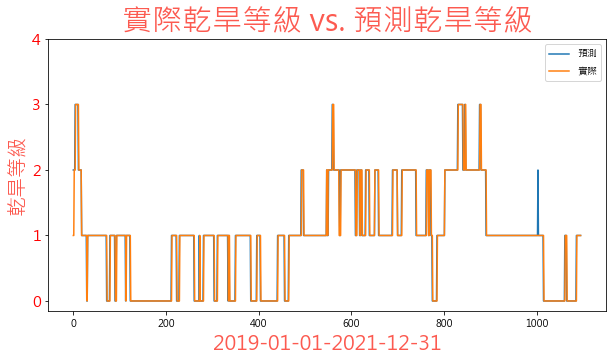

[[267  17   0   0]
 [ 16 540  11   0]
 [  0  12 202   5]
 [  0   0   5  21]]


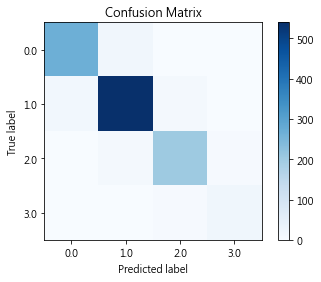

63000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

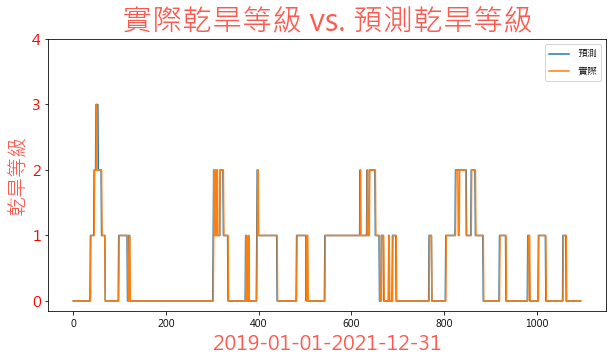

[[664  17   0   0]
 [ 19 310  10   0]
 [  0  13  58   0]
 [  0   0   4   1]]


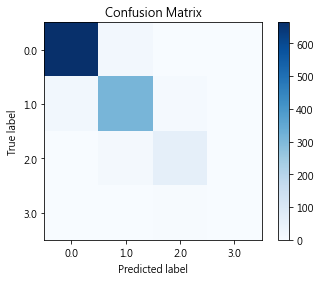

64000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

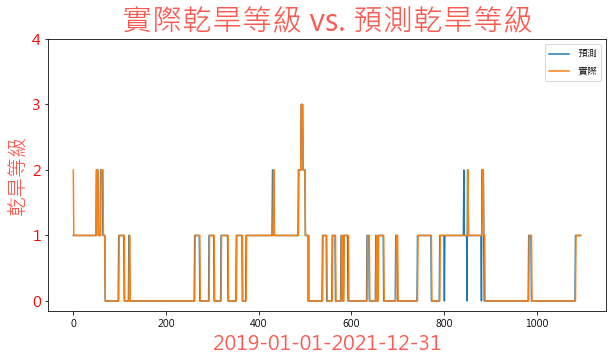

[[614  23   0   0]
 [ 19 403   2   0]
 [  0   7  24   0]
 [  0   0   0   4]]


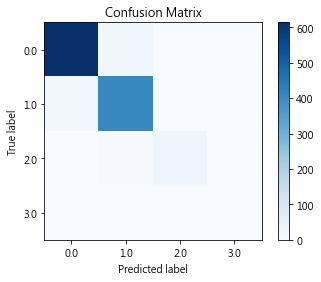

65000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

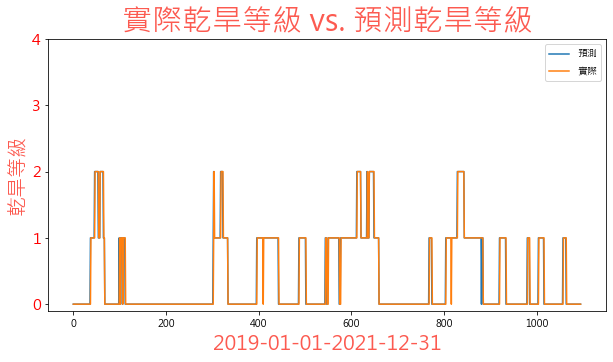

[[714  13   0]
 [ 18 289   6]
 [  0   6  50]]


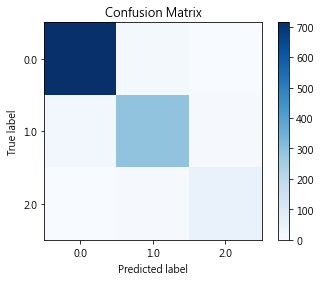

66000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

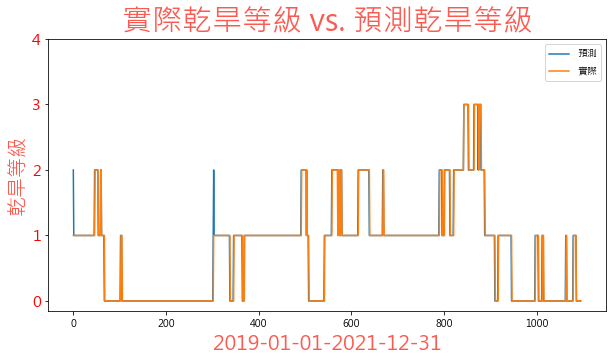

[[406  10   0   0]
 [ 10 509   7   0]
 [  0  14 113   3]
 [  0   0   3  21]]


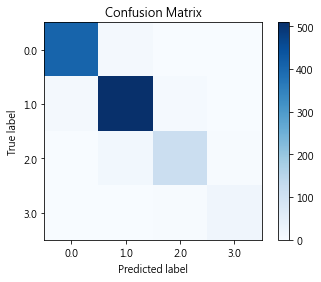

67000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

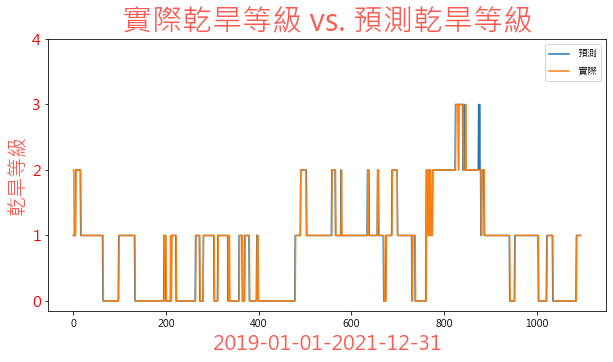

[[382  18   0   0]
 [ 15 505   9   0]
 [  1   7 137   2]
 [  0   0   7  13]]


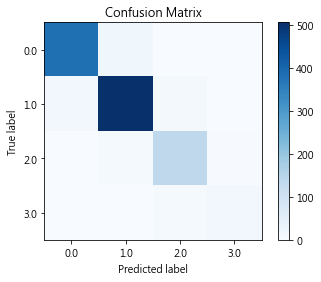

68000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

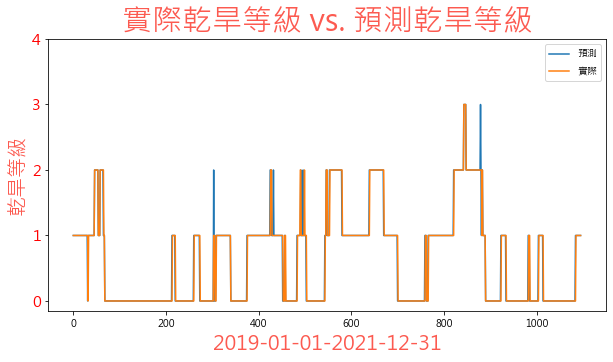

[[544  13   0   0]
 [ 14 373   8   0]
 [  0   8 130   0]
 [  0   0   1   5]]


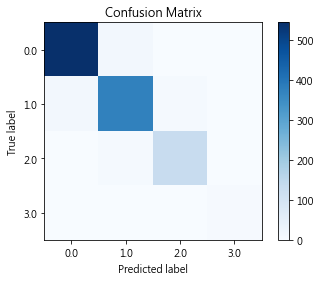

In [512]:
for i, merged_df in output_dict.items():
    df_train = output_dict[i].copy()
    print(i)
    df_train = df_train[['date','value_DSCI']]
    df_train['value_DSCI(t-1)'] = df_train['value_DSCI'].shift(1)
    df_train['value_DSCI(t-2)'] = df_train['value_DSCI'].shift(2)
    df_train['value_DSCI(t-3)'] = df_train['value_DSCI'].shift(3)
    df_train['value_DSCI(t-4)'] = df_train['value_DSCI'].shift(4)
    df_train['value_DSCI(t-5)'] = df_train['value_DSCI'].shift(5)
    df_train['value_DSCI(t-6)'] = df_train['value_DSCI'].shift(6)
    df_train['value_DSCI(t-7)'] = df_train['value_DSCI'].shift(7)
    df_train['value_DSCI(t-8)'] = df_train['value_DSCI'].shift(8)
    df_train['value_DSCI(t-9)'] = df_train['value_DSCI'].shift(9)
    df_train['value_DSCI(t-10)'] = df_train['value_DSCI'].shift(10)
    df_train['value_DSCI(t-11)'] = df_train['value_DSCI'].shift(11)
    df_train['value_DSCI(t-12)'] = df_train['value_DSCI'].shift(12)
    df_train['value_DSCI(t-13)'] = df_train['value_DSCI'].shift(13)
    df_train['value_DSCI(t-14)'] = df_train['value_DSCI'].shift(14)
    df_train['value_DSCI(t-15)'] = df_train['value_DSCI'].shift(15)
    df_train['value_DSCI(t-16)'] = df_train['value_DSCI'].shift(16)
    df_train['value_DSCI(t-17)'] = df_train['value_DSCI'].shift(17)
    df_train['value_DSCI(t-18)'] = df_train['value_DSCI'].shift(18)
    df_train['value_DSCI(t-19)'] = df_train['value_DSCI'].shift(19)
    df_train['value_DSCI(t-20)'] = df_train['value_DSCI'].shift(20)
    df_train['value_DSCI(t-21)'] = df_train['value_DSCI'].shift(21)
    df_train['value_DSCI(t-22)'] = df_train['value_DSCI'].shift(22)
    df_train['value_DSCI(t-23)'] = df_train['value_DSCI'].shift(23)
    df_train['value_DSCI(t-24)'] = df_train['value_DSCI'].shift(24)
    df_train['value_DSCI(t-25)'] = df_train['value_DSCI'].shift(25)
    df_train['value_DSCI(t-26)'] = df_train['value_DSCI'].shift(26)
    df_train['value_DSCI(t-27)'] = df_train['value_DSCI'].shift(27)
    df_train['value_DSCI(t-28)'] = df_train['value_DSCI'].shift(28)
    df_train['value_DSCI(t-29)'] = df_train['value_DSCI'].shift(29)
    df_train['value_DSCI(t-30)'] = df_train['value_DSCI'].shift(30)
    X = df_train[df_train.columns[2:]]  
    y = df_train['value_DSCI']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',  # Use 'regression' for numeric targets
        'metric': 'rmse',
        'learning_rate': 0.1,
        'max_depth': 5,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_leaves': 50,  # Adjust this parameter
        'max_depth': 10,  # Adjust this parameter
    }
    # Create the LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    # Train the model
    num_boost_round = 100
    model = lgb.train(params, train_data, num_boost_round=num_boost_round)
    # Make predictions on the test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)
    print("Mean Squared Error (RMSE):", rmse)
    true_val = df_DSCI[(df_DSCI['date'].between('2019-01-01','2021-12-31')) & (df_DSCI['grid'] == i)].reset_index(drop=True).sort_values('date',ascending=True)
    true_val['value(t-1)'] = true_val['value'].shift(1)
    true_val['value(t-2)'] = true_val['value'].shift(2)
    true_val['value(t-3)'] = true_val['value'].shift(3)
    true_val['value(t-4)'] = true_val['value'].shift(4)
    true_val['value(t-5)'] = true_val['value'].shift(5)
    true_val['value(t-6)'] = true_val['value'].shift(6)
    true_val['value(t-7)'] = true_val['value'].shift(7)
    true_val['value(t-8)'] = true_val['value'].shift(8)
    true_val['value(t-9)'] = true_val['value'].shift(9)
    true_val['value(t-10)'] = true_val['value'].shift(10)
    true_val['value(t-11)'] = true_val['value'].shift(11)
    true_val['value(t-12)'] = true_val['value'].shift(12)
    true_val['value(t-13)'] = true_val['value'].shift(13)
    true_val['value(t-14)'] = true_val['value'].shift(14)
    true_val['value(t-15)'] = true_val['value'].shift(15)
    true_val['value(t-16)'] = true_val['value'].shift(16)
    true_val['value(t-17)'] = true_val['value'].shift(17)
    true_val['value(t-18)'] = true_val['value'].shift(18)
    true_val['value(t-19)'] = true_val['value'].shift(19)
    true_val['value(t-20)'] = true_val['value'].shift(20)
    true_val['value(t-21)'] = true_val['value'].shift(21)
    true_val['value(t-22)'] = true_val['value'].shift(22)
    true_val['value(t-23)'] = true_val['value'].shift(23)
    true_val['value(t-24)'] = true_val['value'].shift(24)
    true_val['value(t-25)'] = true_val['value'].shift(25)
    true_val['value(t-26)'] = true_val['value'].shift(26)
    true_val['value(t-27)'] = true_val['value'].shift(27)
    true_val['value(t-28)'] = true_val['value'].shift(28)
    true_val['value(t-29)'] = true_val['value'].shift(29)
    true_val['value(t-30)'] = true_val['value'].shift(30)
    for_prediction = true_val[(true_val['date'].between('2019-01-01','2021-12-31'))].iloc[:,5:]
    #X_sparse = csr_matrix(for_prediction)
    ans = model.predict(for_prediction)
    ans = [round(i,0) for i in ans]
    True_val = true_val[true_val['date'].between('2019-01-01','2021-12-31')]['value']
    True_val = [round(i,0) for i in True_val]
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    # Plotting the predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(True_val, label='預測')
    # Plotting the actual values
    plt.plot(ans, label='實際')
    # Set labels and title
    plt.title('True vs Predicted Values',color='#f00')
    plt.xlabel('2019-01-01-2021-12-31',color='#FC5A50',fontsize=20)
    plt.ylabel('乾旱等級',color='#FC5A50',fontsize=20)
    plt.title('實際乾旱等級 vs. 預測乾旱等級',fontsize=30,color='#FC5A50')
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',fontsize=15) 
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
    cm = confusion_matrix(True_val,ans)
    print(cm)
    labels = np.unique(True_val)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


10002
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

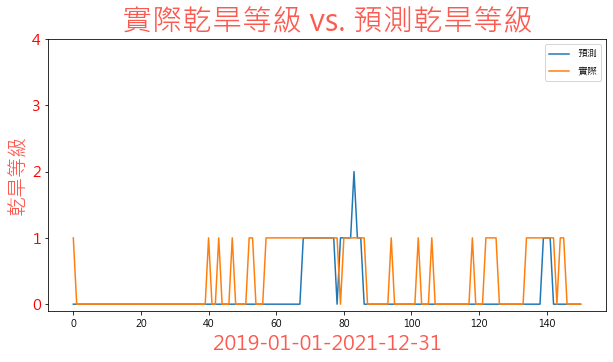

[[96 35  0]
 [ 1 18  0]
 [ 0  1  0]]


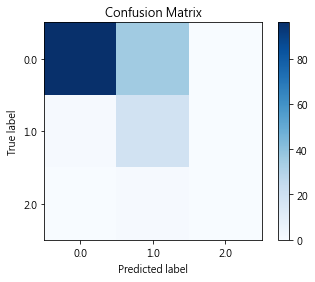

10004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

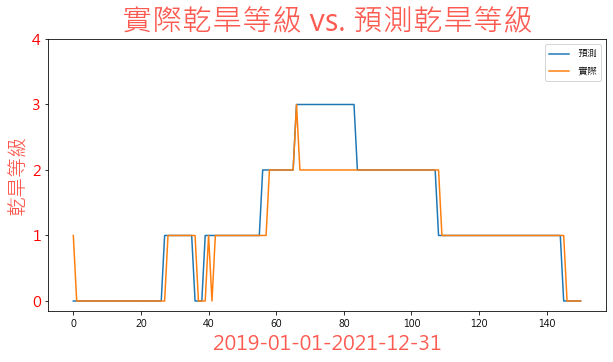

[[33  3  0  0]
 [ 3 59  1  0]
 [ 0  2 32  0]
 [ 0  0 17  1]]


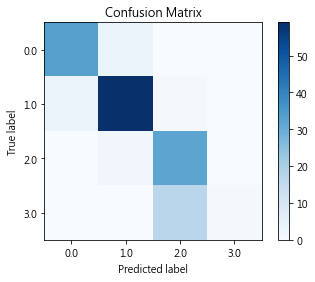

10005
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

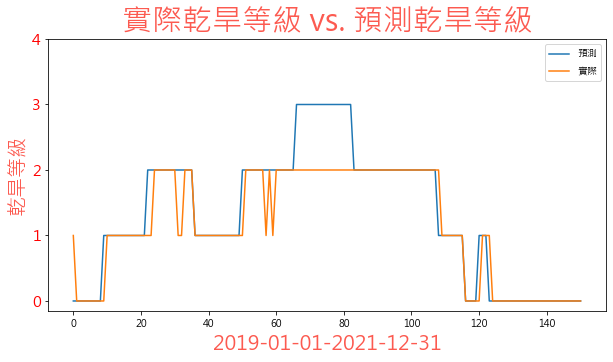

[[39  2  0  0]
 [ 2 35  1  0]
 [ 0  7 48  0]
 [ 0  0 17  0]]


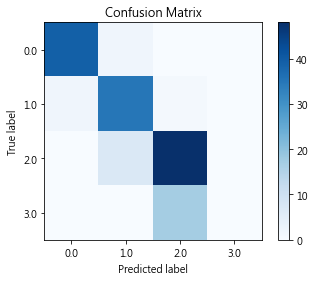

10007
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

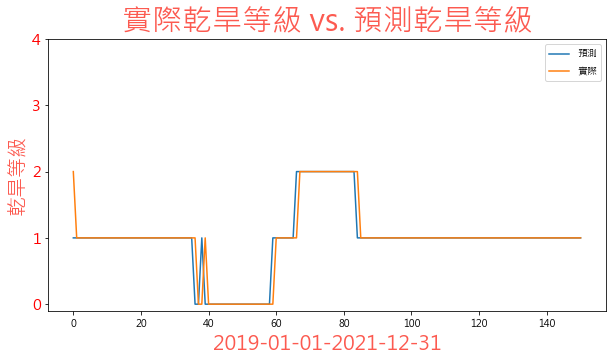

[[ 20   2   0]
 [  2 107   2]
 [  0   1  17]]


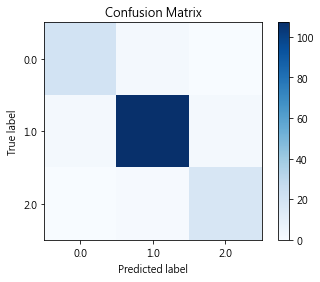

10008
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

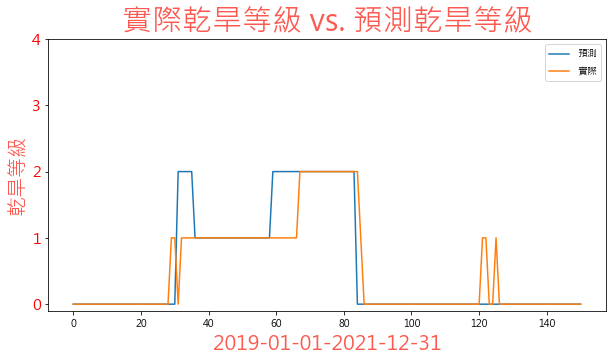

[[91  6  1]
 [ 0 23  0]
 [ 1 12 17]]


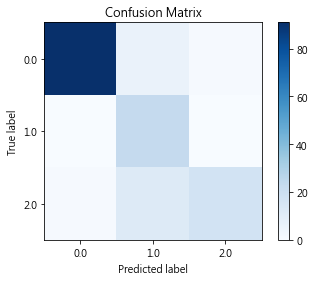

10009
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

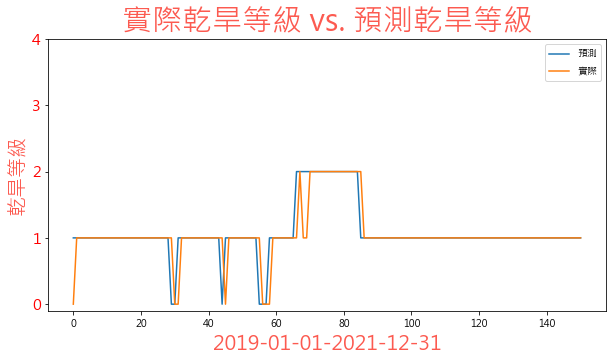

[[  3   3   0]
 [  4 121   1]
 [  0   3  16]]


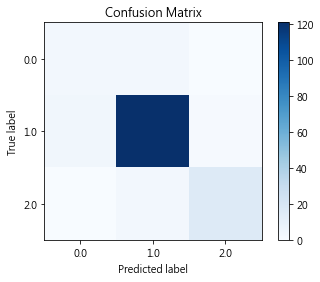

10010
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

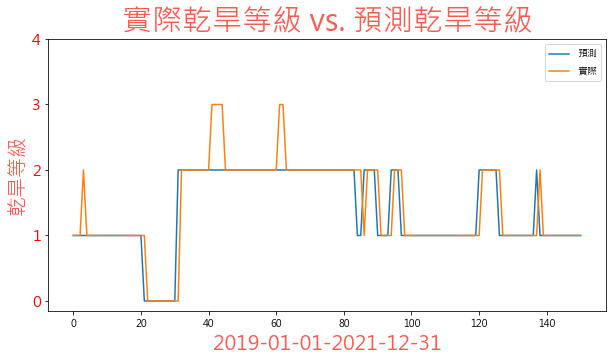

[[ 9  1  0  0]
 [ 0 67  7  0]
 [ 1  4 56  6]
 [ 0  0  0  0]]


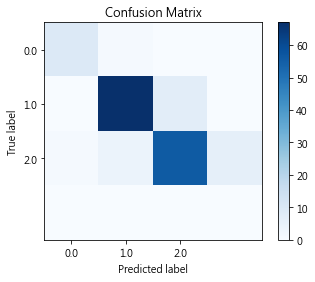

10013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

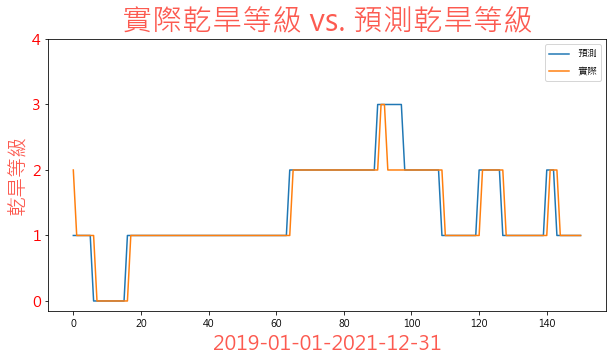

[[ 9  1  0  0]
 [ 1 81  4  0]
 [ 0  3 44  0]
 [ 0  0  6  2]]


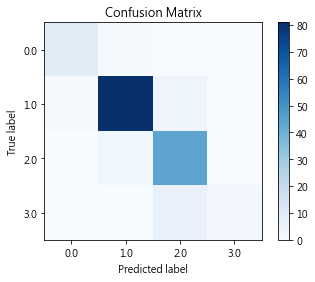

10014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

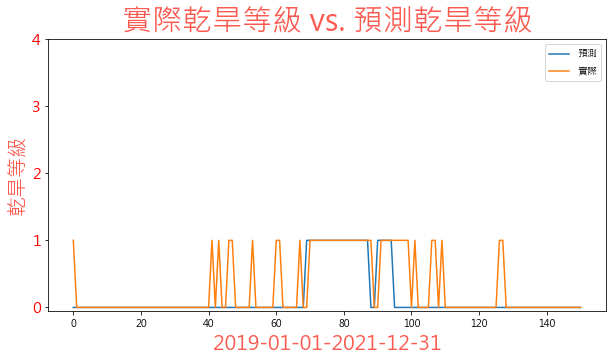

[[106  21]
 [  2  22]]


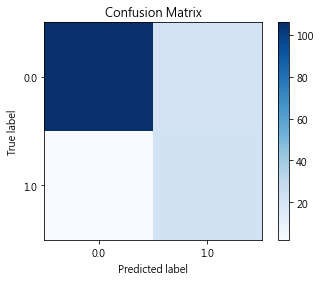

10015
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

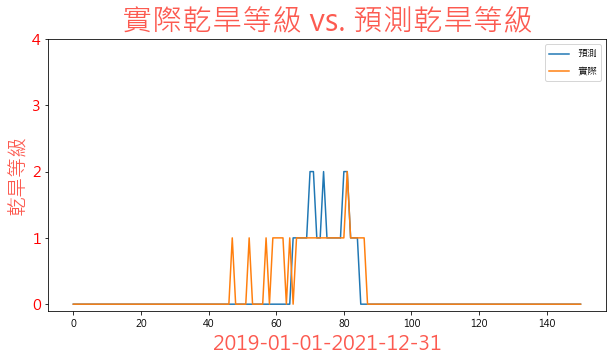

[[121  10   0]
 [  1  14   0]
 [  0   4   1]]


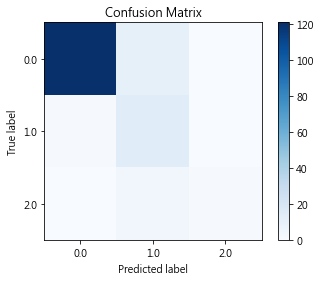

10017
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

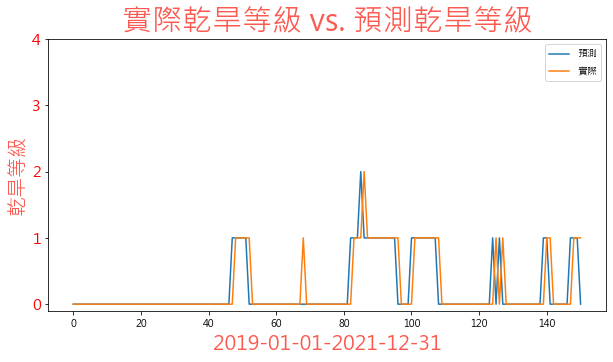

[[109   8   0]
 [  7  25   1]
 [  0   1   0]]


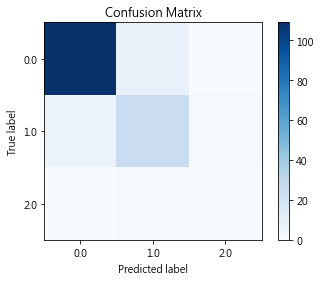

10018
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

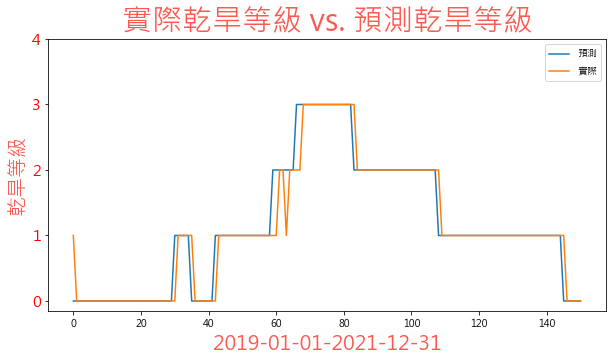

[[40  3  0  0]
 [ 2 56  1  0]
 [ 0  3 28  1]
 [ 0  0  2 15]]


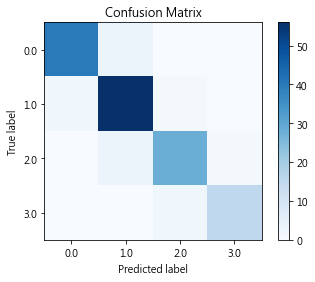

10020
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

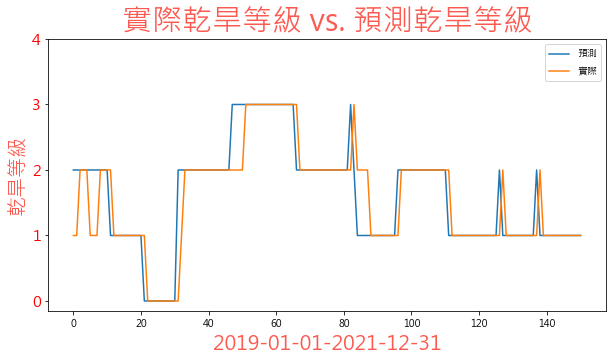

[[ 9  1  0  0]
 [ 0 52  8  0]
 [ 1  9 49  2]
 [ 0  0  5 15]]


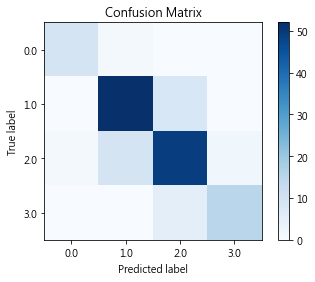

63000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

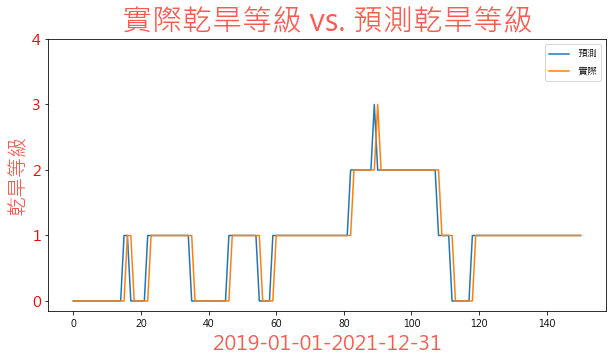

[[37  4  0  0]
 [ 5 78  1  0]
 [ 0  1 23  1]
 [ 0  0  1  0]]


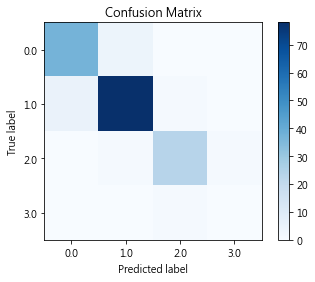

64000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

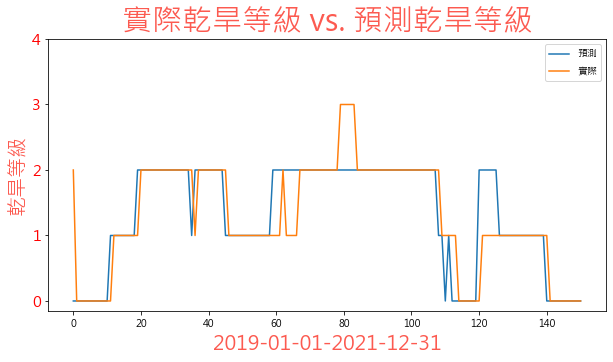

[[26  4  1  0]
 [ 1 36  3  0]
 [ 1 14 60  5]
 [ 0  0  0  0]]


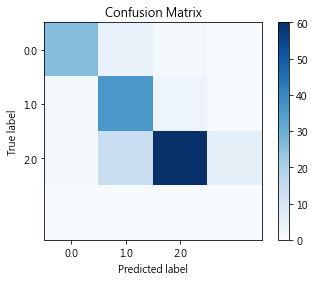

65000
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

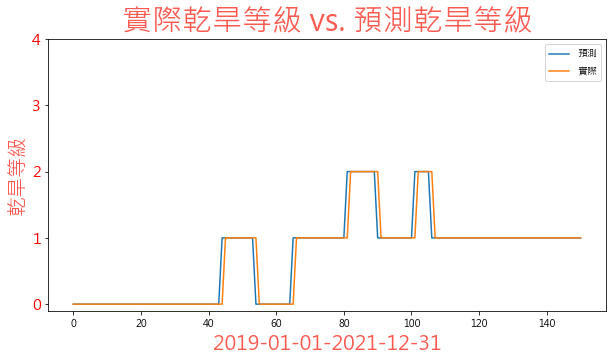

[[54  1  0]
 [ 2 78  2]
 [ 0  2 12]]


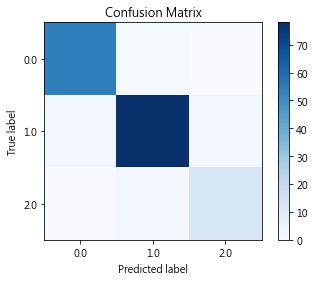

66000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

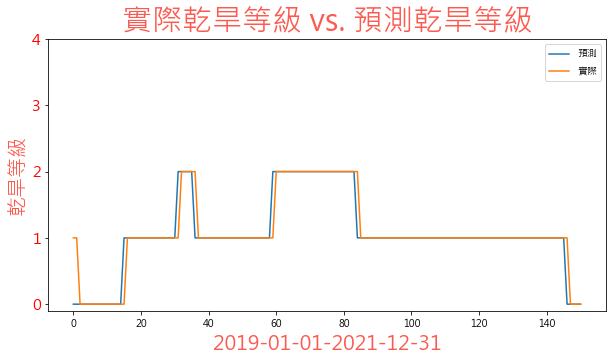

[[17  3  0]
 [ 1 98  2]
 [ 0  2 28]]


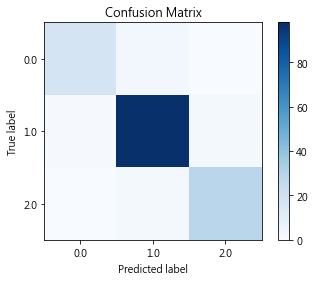

67000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

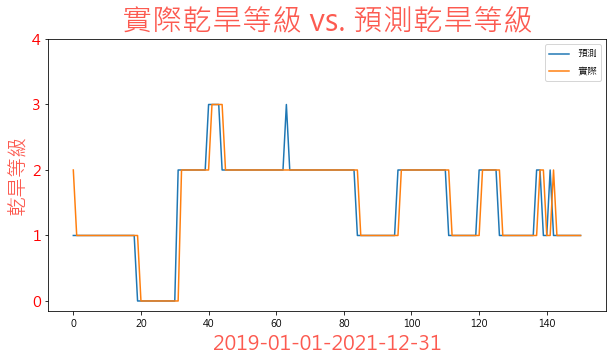

[[11  1  0  0]
 [ 0 56  6  0]
 [ 1  4 66  1]
 [ 0  0  2  3]]


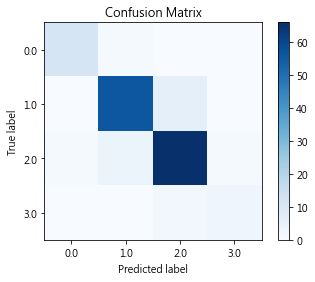

68000
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

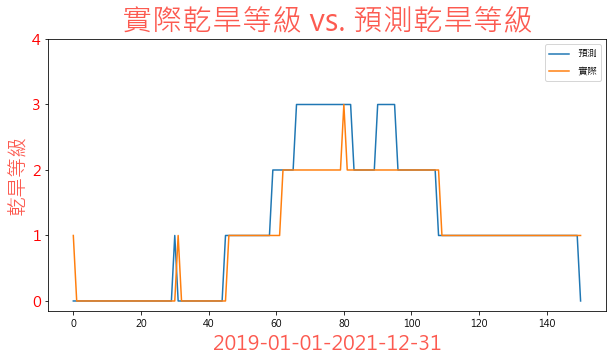

[[42  3  0  0]
 [ 2 54  1  0]
 [ 0  3 23  0]
 [ 0  0 22  1]]


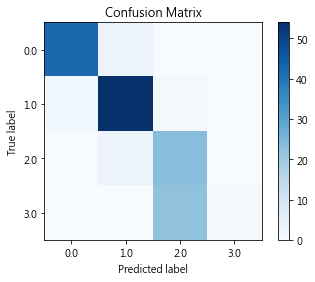

In [515]:
for i, merged_df in output_dict.items():
    df_train = output_dict[i].copy()
    print(i)
    df_train = df_train[['date','value_DSCI']]
    df_train['value_DSCI(t-1)'] = df_train['value_DSCI'].shift(1)
    df_train['value_DSCI(t-2)'] = df_train['value_DSCI'].shift(2)
    df_train['value_DSCI(t-3)'] = df_train['value_DSCI'].shift(3)
    df_train['value_DSCI(t-4)'] = df_train['value_DSCI'].shift(4)
    df_train['value_DSCI(t-5)'] = df_train['value_DSCI'].shift(5)
    df_train['value_DSCI(t-6)'] = df_train['value_DSCI'].shift(6)
    df_train['value_DSCI(t-7)'] = df_train['value_DSCI'].shift(7)
    df_train['value_DSCI(t-8)'] = df_train['value_DSCI'].shift(8)
    df_train['value_DSCI(t-9)'] = df_train['value_DSCI'].shift(9)
    df_train['value_DSCI(t-10)'] = df_train['value_DSCI'].shift(10)
    df_train['value_DSCI(t-11)'] = df_train['value_DSCI'].shift(11)
    df_train['value_DSCI(t-12)'] = df_train['value_DSCI'].shift(12)
    df_train['value_DSCI(t-13)'] = df_train['value_DSCI'].shift(13)
    df_train['value_DSCI(t-14)'] = df_train['value_DSCI'].shift(14)
    df_train['value_DSCI(t-15)'] = df_train['value_DSCI'].shift(15)
    df_train['value_DSCI(t-16)'] = df_train['value_DSCI'].shift(16)
    df_train['value_DSCI(t-17)'] = df_train['value_DSCI'].shift(17)
    df_train['value_DSCI(t-18)'] = df_train['value_DSCI'].shift(18)
    df_train['value_DSCI(t-19)'] = df_train['value_DSCI'].shift(19)
    df_train['value_DSCI(t-20)'] = df_train['value_DSCI'].shift(20)
    df_train['value_DSCI(t-21)'] = df_train['value_DSCI'].shift(21)
    df_train['value_DSCI(t-22)'] = df_train['value_DSCI'].shift(22)
    df_train['value_DSCI(t-23)'] = df_train['value_DSCI'].shift(23)
    df_train['value_DSCI(t-24)'] = df_train['value_DSCI'].shift(24)
    df_train['value_DSCI(t-25)'] = df_train['value_DSCI'].shift(25)
    df_train['value_DSCI(t-26)'] = df_train['value_DSCI'].shift(26)
    df_train['value_DSCI(t-27)'] = df_train['value_DSCI'].shift(27)
    df_train['value_DSCI(t-28)'] = df_train['value_DSCI'].shift(28)
    df_train['value_DSCI(t-29)'] = df_train['value_DSCI'].shift(29)
    df_train['value_DSCI(t-30)'] = df_train['value_DSCI'].shift(30)
    X = df_train[df_train.columns[2:]]  
    y = df_train['value_DSCI']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',  # Use 'regression' for numeric targets
        'metric': 'rmse',
        'learning_rate': 0.1,
        'max_depth': 5,
        'num_leaves': 31,
        'min_data_in_leaf': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'num_leaves': 50,  # Adjust this parameter
        'max_depth': 10,  # Adjust this parameter
    }
    # Create the LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)
    # Train the model
    num_boost_round = 100
    model = lgb.train(params, train_data, num_boost_round=num_boost_round)
    # Make predictions on the test dataset
    y_pred = model.predict(X_test)
    # Evaluate the model's performance
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print('R-squared:', r2)
    print("Mean Squared Error (RMSE):", rmse)
    true_val = df_DSCI[(df_DSCI['date'].between('2023-01-01','2023-05-31')) & (df_DSCI['grid'] == i)].reset_index(drop=True).sort_values('date',ascending=True)
    true_val['value(t-1)'] = true_val['value'].shift(1)
    true_val['value(t-2)'] = true_val['value'].shift(2)
    true_val['value(t-3)'] = true_val['value'].shift(3)
    true_val['value(t-4)'] = true_val['value'].shift(4)
    true_val['value(t-5)'] = true_val['value'].shift(5)
    true_val['value(t-6)'] = true_val['value'].shift(6)
    true_val['value(t-7)'] = true_val['value'].shift(7)
    true_val['value(t-8)'] = true_val['value'].shift(8)
    true_val['value(t-9)'] = true_val['value'].shift(9)
    true_val['value(t-10)'] = true_val['value'].shift(10)
    true_val['value(t-11)'] = true_val['value'].shift(11)
    true_val['value(t-12)'] = true_val['value'].shift(12)
    true_val['value(t-13)'] = true_val['value'].shift(13)
    true_val['value(t-14)'] = true_val['value'].shift(14)
    true_val['value(t-15)'] = true_val['value'].shift(15)
    true_val['value(t-16)'] = true_val['value'].shift(16)
    true_val['value(t-17)'] = true_val['value'].shift(17)
    true_val['value(t-18)'] = true_val['value'].shift(18)
    true_val['value(t-19)'] = true_val['value'].shift(19)
    true_val['value(t-20)'] = true_val['value'].shift(20)
    true_val['value(t-21)'] = true_val['value'].shift(21)
    true_val['value(t-22)'] = true_val['value'].shift(22)
    true_val['value(t-23)'] = true_val['value'].shift(23)
    true_val['value(t-24)'] = true_val['value'].shift(24)
    true_val['value(t-25)'] = true_val['value'].shift(25)
    true_val['value(t-26)'] = true_val['value'].shift(26)
    true_val['value(t-27)'] = true_val['value'].shift(27)
    true_val['value(t-28)'] = true_val['value'].shift(28)
    true_val['value(t-29)'] = true_val['value'].shift(29)
    true_val['value(t-30)'] = true_val['value'].shift(30)
    for_prediction = true_val[(true_val['date'].between('2023-01-01','2023-05-31'))].iloc[:,5:]
    #X_sparse = csr_matrix(for_prediction)
    ans = model.predict(for_prediction)
    ans = [round(i,0) for i in ans]
    True_val = true_val[true_val['date'].between('2023-01-01','2023-05-31')]['value']
    True_val = [round(i,0) for i in True_val]
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
    plt.rcParams['axes.unicode_minus'] = False
    # Plotting the predicted values
    plt.figure(figsize=(10, 5))
    plt.plot(True_val, label='預測')
    # Plotting the actual values
    plt.plot(ans, label='實際')
    # Set labels and title
    plt.title('True vs Predicted Values',color='#f00')
    plt.xlabel('2019-01-01-2021-12-31',color='#FC5A50',fontsize=20)
    plt.ylabel('乾旱等級',color='#FC5A50',fontsize=20)
    plt.title('實際乾旱等級 vs. 預測乾旱等級',fontsize=30,color='#FC5A50')
    plt.yticks(ticks=[0,1,2,3,4],color='#f00',fontsize=15) 
    # Add a legend
    plt.legend()
    # Show the plot
    plt.show()
    cm = confusion_matrix(True_val,ans)
    print(cm)
    labels = np.unique(True_val)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


t-30~t-1預測t,t-30~t-1預測t+1,t-30~t-1預測t+2,t-30~t-1預測t+3,t-30~t-1預測t+4.......,t-30~t-1預測t+30

In [517]:
df_68000_DSCI = output_dict[68000][['date','value_DSCI']]
df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
df_68000_DSCI['value_DSCI(t-2)'] = df_68000_DSCI['value_DSCI'].shift(2)
df_68000_DSCI['value_DSCI(t-3)'] = df_68000_DSCI['value_DSCI'].shift(3)
df_68000_DSCI['value_DSCI(t-4)'] = df_68000_DSCI['value_DSCI'].shift(4)
df_68000_DSCI['value_DSCI(t-5)'] = df_68000_DSCI['value_DSCI'].shift(5)
df_68000_DSCI['value_DSCI(t-6)'] = df_68000_DSCI['value_DSCI'].shift(6)
df_68000_DSCI['value_DSCI(t-7)'] = df_68000_DSCI['value_DSCI'].shift(7)
df_68000_DSCI['value_DSCI(t-8)'] = df_68000_DSCI['value_DSCI'].shift(8)
df_68000_DSCI['value_DSCI(t-9)'] = df_68000_DSCI['value_DSCI'].shift(9)
df_68000_DSCI['value_DSCI(t-10)'] = df_68000_DSCI['value_DSCI'].shift(10)
df_68000_DSCI['value_DSCI(t-11)'] = df_68000_DSCI['value_DSCI'].shift(11)
df_68000_DSCI['value_DSCI(t-12)'] = df_68000_DSCI['value_DSCI'].shift(12)
df_68000_DSCI['value_DSCI(t-13)'] = df_68000_DSCI['value_DSCI'].shift(13)
df_68000_DSCI['value_DSCI(t-14)'] = df_68000_DSCI['value_DSCI'].shift(14)
df_68000_DSCI['value_DSCI(t-15)'] = df_68000_DSCI['value_DSCI'].shift(15)
df_68000_DSCI['value_DSCI(t-16)'] = df_68000_DSCI['value_DSCI'].shift(16)
df_68000_DSCI['value_DSCI(t-17)'] = df_68000_DSCI['value_DSCI'].shift(17)
df_68000_DSCI['value_DSCI(t-18)'] = df_68000_DSCI['value_DSCI'].shift(18)
df_68000_DSCI['value_DSCI(t-19)'] = df_68000_DSCI['value_DSCI'].shift(19)
df_68000_DSCI['value_DSCI(t-20)'] = df_68000_DSCI['value_DSCI'].shift(20)
df_68000_DSCI['value_DSCI(t-21)'] = df_68000_DSCI['value_DSCI'].shift(21)
df_68000_DSCI['value_DSCI(t-22)'] = df_68000_DSCI['value_DSCI'].shift(22)
df_68000_DSCI['value_DSCI(t-23)'] = df_68000_DSCI['value_DSCI'].shift(23)
df_68000_DSCI['value_DSCI(t-24)'] = df_68000_DSCI['value_DSCI'].shift(24)
df_68000_DSCI['value_DSCI(t-25)'] = df_68000_DSCI['value_DSCI'].shift(25)
df_68000_DSCI['value_DSCI(t-26)'] = df_68000_DSCI['value_DSCI'].shift(26)
df_68000_DSCI['value_DSCI(t-27)'] = df_68000_DSCI['value_DSCI'].shift(27)
df_68000_DSCI['value_DSCI(t-28)'] = df_68000_DSCI['value_DSCI'].shift(28)
df_68000_DSCI['value_DSCI(t-29)'] = df_68000_DSCI['value_DSCI'].shift(29)
df_68000_DSCI['value_DSCI(t-30)'] = df_68000_DSCI['value_DSCI'].shift(30)

C:\Users\tangkai\AppData\Local\Temp\ipykernel_2160\3184894093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t-1)'] = df_68000_DSCI['value_DSCI'].shift(1)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_2160\3184894093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_68000_DSCI['value_DSCI(t-2)'] = df_68000_DSCI['value_DSCI'].shift(2)
C:\Users\tangkai\AppData\Local\Temp\ipykernel_2160\3184894093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [518]:
X = df_68000_DSCI[df_68000_DSCI.columns[2:]]  
y = df_68000_DSCI['value_DSCI']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',  # Use 'regression' for numeric targets
    'metric': 'rmse',
    'learning_rate': 0.1,
    'max_depth': 5,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'num_leaves': 50,  # Adjust this parameter
    'max_depth': 10,  # Adjust this parameter
}

# Create the LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Train the model
num_boost_round = 100
t1_model = lgb.train(params, train_data, num_boost_round=num_boost_round)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

In [519]:
true_val = df_DSCI[(df_DSCI['date'].between('2019-01-01','2019-01-31')) & (df_DSCI['grid'] == 68000)].reset_index(drop=True).sort_values('date',ascending=True)
true_val['value(t-1)'] = true_val['value'].shift(1)
true_val['value(t-2)'] = true_val['value'].shift(2)
true_val['value(t-3)'] = true_val['value'].shift(3)
true_val['value(t-4)'] = true_val['value'].shift(4)
true_val['value(t-5)'] = true_val['value'].shift(5)
true_val['value(t-6)'] = true_val['value'].shift(6)
true_val['value(t-7)'] = true_val['value'].shift(7)
true_val['value(t-8)'] = true_val['value'].shift(8)
true_val['value(t-9)'] = true_val['value'].shift(9)
true_val['value(t-10)'] = true_val['value'].shift(10)
true_val['value(t-11)'] = true_val['value'].shift(11)
true_val['value(t-12)'] = true_val['value'].shift(12)
true_val['value(t-13)'] = true_val['value'].shift(13)
true_val['value(t-14)'] = true_val['value'].shift(14)
true_val['value(t-15)'] = true_val['value'].shift(15)
true_val['value(t-16)'] = true_val['value'].shift(16)
true_val['value(t-17)'] = true_val['value'].shift(17)
true_val['value(t-18)'] = true_val['value'].shift(18)
true_val['value(t-19)'] = true_val['value'].shift(19)
true_val['value(t-20)'] = true_val['value'].shift(20)
true_val['value(t-21)'] = true_val['value'].shift(21)
true_val['value(t-22)'] = true_val['value'].shift(22)
true_val['value(t-23)'] = true_val['value'].shift(23)
true_val['value(t-24)'] = true_val['value'].shift(24)
true_val['value(t-25)'] = true_val['value'].shift(25)
true_val['value(t-26)'] = true_val['value'].shift(26)
true_val['value(t-27)'] = true_val['value'].shift(27)
true_val['value(t-28)'] = true_val['value'].shift(28)
true_val['value(t-29)'] = true_val['value'].shift(29)
true_val['value(t-30)'] = true_val['value'].shift(30)
true_val

,date,grid,value,level,id,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
0,2019-01-01,68000,1.00,1.0,153444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,68000,1.00,1.0,153463,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,68000,0.67,1.0,153482,1.00,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,68000,0.67,1.0,153501,0.67,1.00,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-05,68000,0.67,1.0,153520,0.67,0.67,1.00,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-01-06,68000,0.67,1.0,153539,0.67,0.67,0.67,1.00,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2019-01-07,68000,0.67,1.0,153558,0.67,0.67,0.67,0.67,1.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2019-01-08,68000,0.67,1.0,153577,0.67,0.67,0.67,0.67,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2019-01-09,68000,0.67,1.0,153596,0.67,0.67,0.67,0.67,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2019-01-10,68000,0.67,1.0,153615,0.67,0.67,0.67,0.67,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [520]:
for_prediction = true_val[(true_val['date'].between('2019-01-01','2019-01-31'))].iloc[:,5:]

In [521]:
for_prediction

,value(t-1),value(t-2),value(t-3),value(t-4),value(t-5),value(t-6),value(t-7),value(t-8),value(t-9),value(t-10),...,value(t-21),value(t-22),value(t-23),value(t-24),value(t-25),value(t-26),value(t-27),value(t-28),value(t-29),value(t-30)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.67,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.67,0.67,1.00,1.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.67,0.67,0.67,1.00,1.00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.67,0.67,0.67,0.67,1.00,1.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.67,0.67,0.67,0.67,0.67,1.00,1.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.67,0.67,0.67,0.67,0.67,0.67,1.00,1.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.67,0.67,0.67,0.67,0.67,0.67,0.67,1.00,1.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [523]:
#X_sparse = csr_matrix(for_prediction)
ans = t1_model.predict(for_prediction)
#ans = [round(i,0) for i in ans]
ans

array([1.4924263 , 1.29434008, 1.0480454 , 0.63294018, 0.79515448,
       0.77455797, 0.78531063, 0.75780541, 0.624445  , 0.58736726,
       0.63054134, 0.71767787, 0.63677606, 0.63187005, 0.68155554,
       0.77573376, 0.79406385, 0.76079178, 0.72278203, 0.70068373,
       0.71265346, 0.71469096, 0.6885398 , 0.63984376, 0.6013671 ,
       0.62984725, 0.61117907, 0.64478612, 0.63344493, 0.71218736,
       0.65293182])

In [524]:
True_val = true_val[true_val['date'].between('2019-01-01','2019-01-31')]['value']
#True_val = [round(i,0) for i in True_val]
True_val

0     1.00
1     1.00
2     0.67
3     0.67
4     0.67
5     0.67
6     0.67
7     0.67
8     0.67
9     0.67
10    0.67
11    0.67
12    0.67
13    0.67
14    0.67
15    0.67
16    0.67
17    0.67
18    0.67
19    0.67
20    0.67
21    0.67
22    0.67
23    0.67
24    0.67
25    0.67
26    0.67
27    0.67
28    0.67
29    0.67
30    0.67
Name: value, dtype: float64